In [43]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC

In [44]:
train = pd.read_csv('/kaggle/input/gold-dataset/train_data.csv', sep=',')

In [45]:
test = pd.read_csv('/kaggle/input/gold-dataset/test_data.csv', sep=',')

In [46]:
train.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,694,74.00,Chuyên gia nhận định các yếu tố đang nghiêng v...,15/01/2024,77.00,08:30,Giá vàng hôm nay 15/1: Vàng sẽ tăng lại mức đỉ...,increase
1,638,70.10,Giá vàng giằng co trước những diễn biến khó đo...,02/11/2023,70.80,08:30,"Giá vàng hôm nay 2/11: Đón tin xấu, giá vàng d...",decrease
2,133,54.10,Giá vàng hôm nay ngày 02/12: Sau nhiều diễn bi...,02/12/2020,54.75,08:30,Giá vàng hôm nay ngày 02/12: Giá vàng đột ngột...,increase
3,355,69.55,. Giá vàng năm châu không ngừng cắm đầu lao dố...,20/04/2022,70.25,08:55,"Giá vàng hôm nay 20/4: Hụt hơi, vàng quay đầu ...",decrease
4,55,60.60,Giá vàng lúc 9h34 ngày 7/8/2020 tiếp tục lập đ...,07/08/2020,62.20,10:10,Giá vàng ngày 7/8/2020: lập đỉnh mới trên 62 t...,increase


In [47]:
test.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,595,67.50,“Ngay cả khi vàng và bạc không tăng giá thì ch...,29/08/2023,68.10,09:00,Giá vàng hôm nay 29/8: USD suy yếu giúp vàng b...,increase
1,587,67.00,Hầu hết các nhà phân tích đều cho rằng giá vàn...,19/08/2023,67.70,08:20,"Giá vàng hôm nay 19/8: Áp lực bủa vây, vàng ch...",decrease
2,543,66.35,Nhà phân tích thị trường cấp cao Edward Moya c...,28/06/2023,66.95,14:15,"Giá vàng hôm nay 28/6: Tiếp tục đi xuống, có n...",decrease
3,644,69.30,"Hiện tại, thị trường đang chờ đợi bài phát biể...",10/11/2023,70.30,08:35,Giá vàng hôm nay 10/11: Tăng nhẹ chờ thời,decrease
4,487,66.65,Giá vàng đã có lúc giảm sâu xuống ngưỡng 1.944...,28/03/2023,67.35,09:05,"Giá vàng hôm nay 28/3: Dân buôn chốt lời, vàng...",decrease


In [48]:
def get_config():
    config = {'batch_size': 8,
              'model_name': 'uitnlp/visobert',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 128,
              'eos': '[SEP]'
              
    }
    return config 

In [49]:
config = get_config()

In [50]:
train['word_embedding'] = train['TITLE'] 
test['word_embedding'] = test['TITLE'] 

### Preprocessing

In [51]:
def preprocess(text):
    # Loại bỏ các ký tự xuống dòng và thay thế chúng bằng một khoảng trắng
    text = re.sub(r'\r\n+', ' ', text)
    
    # Chuẩn hóa khoảng trắng để không có nhiều khoảng trắng liên tiếp
    text = re.sub(r'\s+', ' ', text)
    
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s/]', '', text)
    
    # Thêm dấu chấm câu để tách các câu
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)  # Thêm khoảng trắng giữa số và chữ
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)   # Thêm khoảng trắng giữa số và chữ nếu không có khoảng trắng
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)   # Thêm khoảng trắng giữa chữ và số nếu không có khoảng trắng
    text = re.sub(r'(đồng lượng|usdoz|lượng)', r'\1.', text)  # Thêm dấu chấm sau các đơn vị đo lường
    
    # Loại bỏ khoảng trắng thừa ở đầu và cuối chuỗi
    text = text.strip()

    # Chuyển thành chữ thường
    text = text.lower()

    return text

In [11]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: preprocess(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: preprocess(x))

In [52]:
train['labels'] = train['labels'].apply(lambda x: 1 if x == 'increase' else 0)

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
# create model
model = AutoModel.from_pretrained(config['model_name']).to(device)

tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Creating Word Embedding 

In [55]:
def word_embedding(x):
    inputs = tokenizer(x, truncation=True, padding=True, return_tensors='pt', max_length=config['max_length']).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().cpu().numpy()[0]

In [56]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: word_embedding(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: word_embedding(x))

### Training

In [57]:
svm = SVC()

In [58]:
# training
print("========== Start training ==========")
svm.fit(train['word_embedding'].values.tolist(), train['labels'].values)
print("========== End training ==========")

========== Start training ==========
========== End training ==========


In [59]:
preds = svm.predict(test['word_embedding'].values.tolist())

In [60]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [61]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [62]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.8718
Precision : 0.8493
Recall    : 0.8732
F1 Score  : 0.8611


Confusion metrics

Confusion matrix is: [[74 11]
 [ 9 62]]


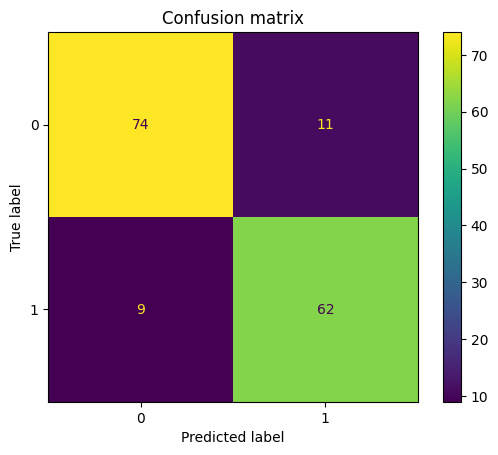

In [63]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()